## ML Models for Survival of Swainson Thrushs

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
import shap
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib.patches import Patch

In [8]:
file_path = "https://raw.githubusercontent.com/sarahvastani/portfolio/refs/heads/main/Survival_of_Migration_Project/Dataset/Dataset1.phiSurvival.20250707.csv"
df = pd.read_csv(file_path)
df

,reference,name_in_vcf,release_site,capture_site,release_year,tag_type,sex_binary,age_release,release_gps.n,release_gps.w,...,range_norm_p9,range_norm_p10,range_norm_releaseDay,range_norm_fall_detectDay1,range_norm_fall_bearing1,range_norm_bodyCondition,ch_10days,ch,phi,phi_binary
0,AH17K18,AH17K18,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.666667,NaN,0.000000,NaN,NaN,0.849981,days_100110000000000000000000000000,100110000000000000000000000000,0.000000e+00,0
1,AH18K02,AH18K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.833333,NaN,0.043478,0.250,0.424781,0.674626,days_110000100000000000000000000000,110000100000000000000000000000,1.084520e-38,0
2,AH22K02,AH22K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.388889,NaN,0.217391,0.500,0.731704,0.347152,days_101000000000000000000000000000,101000000000000000000000000000,8.884759e-14,0
3,AH22K04,AH22K04_S154_L001,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.444444,NaN,0.217391,NaN,NaN,0.571480,days_100000000000000000000000000000,100000000000000000000000000000,1.285971e-240,0
4,AH22K09,AH22K09,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.444444,NaN,0.217391,0.550,0.836626,0.294291,days_101000000000000000000000000000,101000000000000000000000000000,8.884759e-14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,EH31H02,EH31H02,Pemberton,Pemberton,2023,radio,1,HY,50.220153,-122.884084,...,0.777778,0.375,0.608696,0.600,0.474724,0.468136,days_101001000000000000000000000000,101001000000000000000000000000,0.000000e+00,0
475,EH31H03,EH31H03,Pemberton,Pemberton,2023,radio,1,HY,50.220153,-122.884084,...,0.500000,0.250,0.608696,0.825,0.474724,0.468227,days_101100000000000000000000000000,101100000000000000000000000000,2.362661e-23,0
476,EH31H07,EH31H07,Pemberton,Pemberton,2023,radio,0,HY,50.220153,-122.884084,...,0.555556,0.500,0.608696,0.900,0.474724,0.281292,days_100110000000000000000000000000,100110000000000000000000000000,0.000000e+00,0
477,EH31H08,EH31H08,Pemberton,Pemberton,2023,radio,0,HY,50.220153,-122.884084,...,0.444444,0.250,0.608696,0.425,0.352253,0.513245,days_110100100000000000000000100111,110100100000000000000000100111,1.000000e+00,1


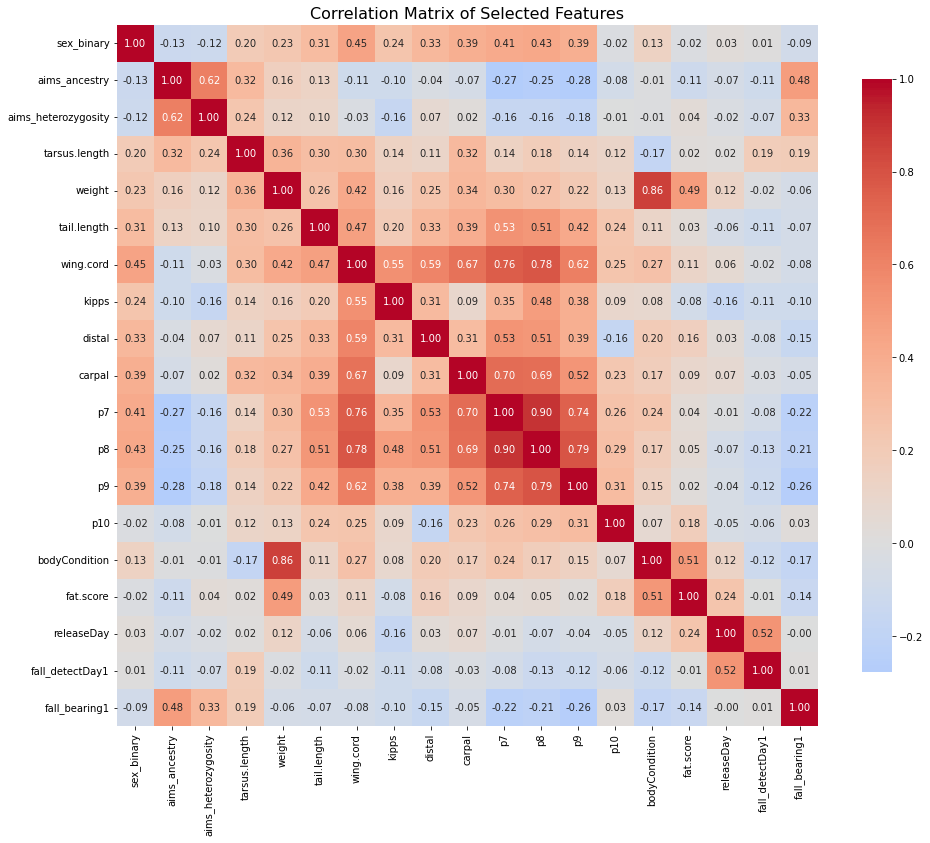

In [69]:
# List of columns to include in the correlation matrix
cols_of_interest = [
    'sex_binary', 'aims_ancestry', 'aims_heterozygosity', 'tarsus.length', 'weight',
    'tail.length', 'wing.cord', 'kipps', 'distal', 'carpal', 'p7', 'p8', 'p9', 'p10',
    'bodyCondition', 'fat.score', 'releaseDay', 'fall_detectDay1', 'fall_bearing1'
]

# Keep only the selected columns (drop any that might be missing)
df_corr = df[cols_of_interest].copy()

# Drop rows with any missing values (or you could use imputation if preferred)
df_corr = df_corr.dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(numeric_only=True)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={"shrink": 0.8}, square=True)
plt.title("Correlation Matrix of Selected Features", fontsize=16)
plt.tight_layout()

# 🔽 Save to PDF
plt.savefig("correlation_matrix.pdf", format="pdf")
plt.show()

In [11]:
features = ['fall_detectDay1', 'fall_bearing1',
            'distal', 'p10', 'bodyCondition', 'tarsus.length',
            'kipps', 'tail.length', 'wing.cord', 
            'sex_binary', 'releaseDay', 'aims_heterozygosity', 
            'aims_ancestry', 'release_year']

X = df[features]
y = df['phi_binary']
y = y.astype(int) 

In [60]:
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('smote', SMOTE(random_state=42)),
    ('brf', BalancedRandomForestClassifier(random_state=42))
])

param_grid = {
    'brf__n_estimators': [100, 200, 300],
    'brf__max_depth': [10, 20, None],
    'brf__max_features': ['sqrt', 'log2', None],
    'brf__min_samples_split': [2, 5, 10],
    'brf__min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=40,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)


print(search.best_params_)
best_model = search.best_estimator_

# Evaluate best_model on test set (with threshold tuning as you already do)

# Predict probabilities
probs = best_model.predict_proba(X_test)[:, 1]

# Threshold tuning
thresholds = np.linspace(0.4, 0.7, 100)
results = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    results.append({
        'threshold': t,
        'accuracy': report['accuracy'],
        'class0_recall': report['0']['recall'],
        'class1_recall': report['1']['recall'],
        'class0_f1': report['0']['f1-score'],
        'class1_f1': report['1']['f1-score'],
        'macro_f1': (report['0']['f1-score'] + report['1']['f1-score']) / 2
    })

results_df = pd.DataFrame(results)
best_row = results_df.sort_values(by='macro_f1', ascending=False).iloc[0]
best_thresh = best_row['threshold']

print("\n📊 Final Confusion Matrix and Report:")
print(confusion_matrix(y_test, final_preds))
print(classification_report(y_test, final_preds, zero_division=0))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.


{'brf__n_estimators': 100, 'brf__min_samples_split': 10, 'brf__min_samples_leaf': 4, 'brf__max_features': None, 'brf__max_depth': None}

✅ Best Threshold (macro F1): 0.639
accuracy         0.716667
class0_recall    0.819277
class1_recall    0.486486
class0_f1        0.800000
class1_f1        0.514286
macro_f1         0.657143
Name: 79, dtype: float64

📊 Final Confusion Matrix and Report:
[[68 15]
 [19 18]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        83
           1       0.55      0.49      0.51        37

    accuracy                           0.72       120
   macro avg       0.66      0.65      0.66       120
weighted avg       0.71      0.72      0.71       120



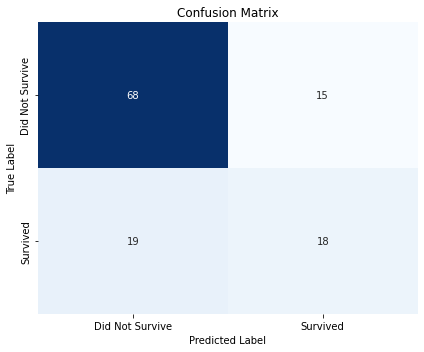

In [67]:
# Compute confusion matrix
cm = confusion_matrix(y_test, final_preds)
labels = ['Did Not Survive', 'Survived']

# Plot with seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

# 🔽 Save to PDF
plt.savefig("confusion_matrix.pdf", format="pdf")
plt.show()

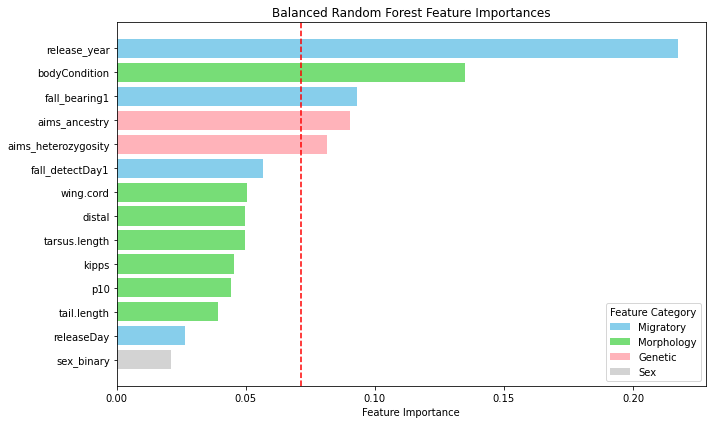

In [64]:
feature_categories = {
    'fall_detectDay1': 'Migratory',
    'fall_bearing1': 'Migratory',
    'releaseDay': 'Migratory',
    'release_year': 'Migratory',  
    'distal': 'Morphology',
    'p10': 'Morphology',
    'bodyCondition': 'Morphology',
    'tarsus.length': 'Morphology',
    'kipps': 'Morphology',
    'tail.length': 'Morphology',
    'wing.cord': 'Morphology',
    'aims_heterozygosity': 'Genetic',
    'aims_ancestry': 'Genetic',
    'sex_binary': 'Sex'
}

category_colors = {
    'Migratory': '#87ceeb',  # Light blue
    'Morphology': '#77dd77', # Light green
    'Genetic': '#ffb3ba',    # Light pink
    'Sex': '#d3d3d3'         # Light gray
}

# Get feature names and importances
feature_names = X_train.columns
importances = best_model.named_steps['brf'].feature_importances_

# Clean feature names for category lookup
clean_names = [f.replace('norm_', '') for f in feature_names]

# Assign categories based on your mapping
categories = [feature_categories.get(name, 'Other') for name in clean_names]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Category': categories
}).sort_values(by='Importance', ascending=False)

# Assign colors based on category
colors = importance_df['Category'].map(category_colors).fillna('gray')

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df['Feature'],
    importance_df['Importance'],
    color=colors
)
plt.gca().invert_yaxis()
plt.axvline(x=1/len(feature_names), color='red', linestyle='--', label='1 / num_features')

# Create legend for only used categories
used_categories = importance_df['Category'].unique()
legend_elements = [
    Patch(facecolor=category_colors.get(cat, 'gray'), label=cat)
    for cat in used_categories
]

plt.legend(handles=legend_elements, title="Feature Category")
plt.xlabel("Feature Importance")
plt.title("Balanced Random Forest Feature Importances")
plt.tight_layout()


# 🔽 Save to PDF
plt.savefig("feature_importances.pdf", format="pdf")
plt.show()

In [70]:
# 🔽 Save feature importances to CSV
importance_df.to_csv("feature_importances.csv", index=False)


<Figure size 432x288 with 0 Axes>

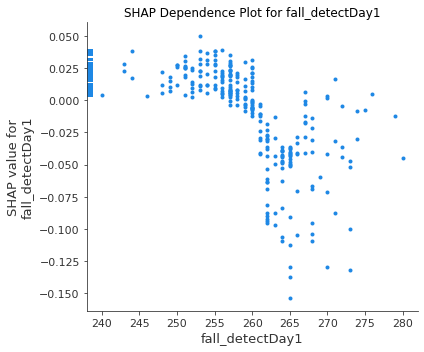

<Figure size 432x288 with 0 Axes>

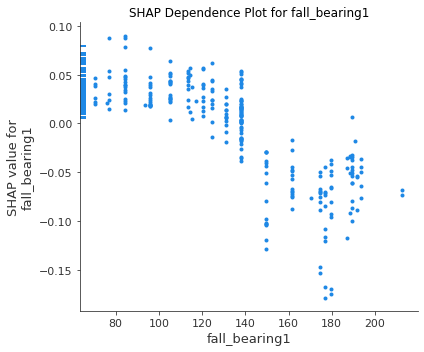

<Figure size 432x288 with 0 Axes>

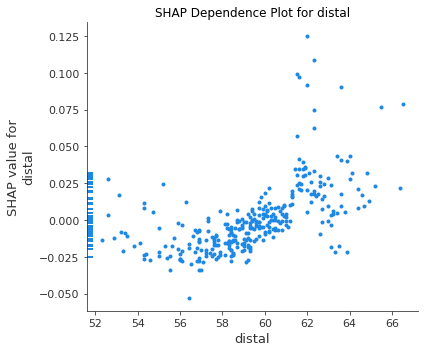

<Figure size 432x288 with 0 Axes>

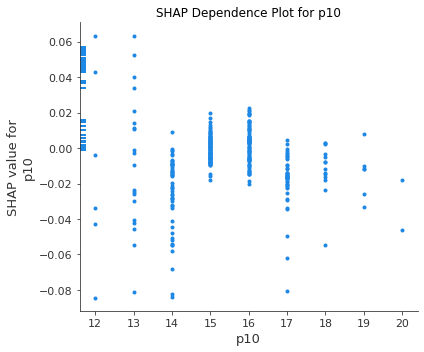

<Figure size 432x288 with 0 Axes>

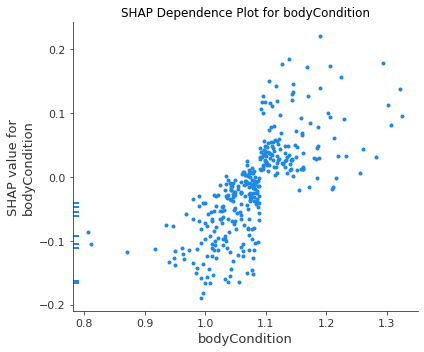

<Figure size 432x288 with 0 Axes>

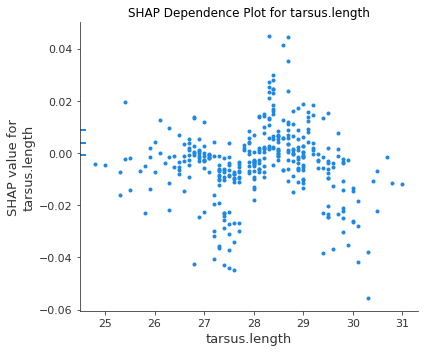

<Figure size 432x288 with 0 Axes>

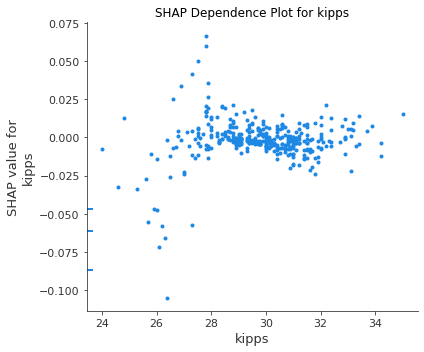

<Figure size 432x288 with 0 Axes>

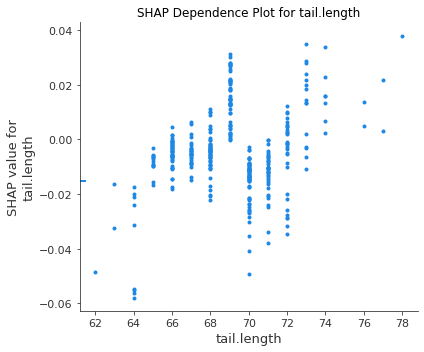

<Figure size 432x288 with 0 Axes>

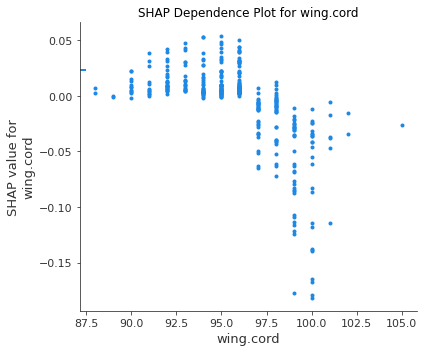

<Figure size 432x288 with 0 Axes>

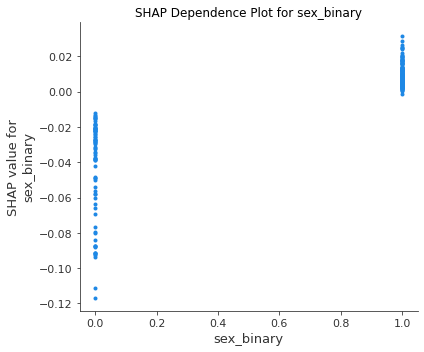

<Figure size 432x288 with 0 Axes>

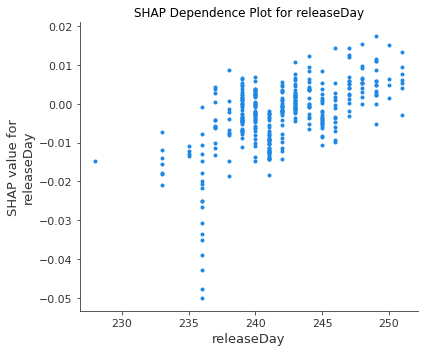

<Figure size 432x288 with 0 Axes>

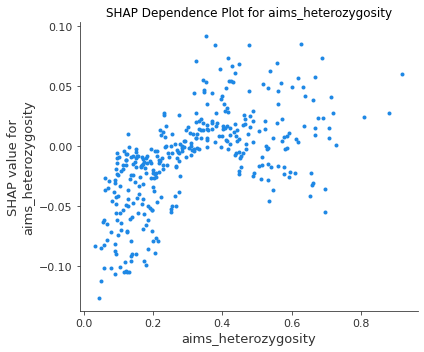

<Figure size 432x288 with 0 Axes>

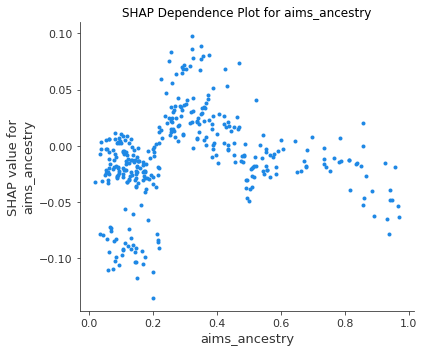

<Figure size 432x288 with 0 Axes>

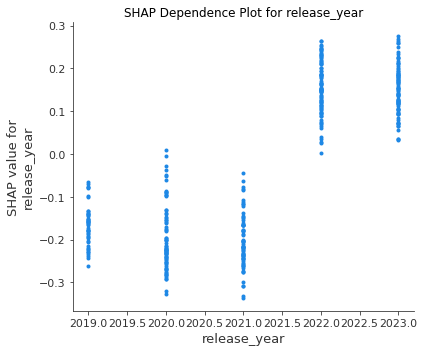

In [66]:
# Get the trained BRF model
model = best_model.named_steps['brf']

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# For binary classification, shap_values is a list (one array per class)
# Use the SHAP values for the positive class (index 1)
shap_vals_class1 = shap_values[1]

# Loop through each feature to make 1D dependence plots
for i, feature in enumerate(X_train.columns):
    plt.figure(figsize=(6, 4))
    shap.dependence_plot(
        ind=feature,
        shap_values=shap_vals_class1,
        features=X_train,
        interaction_index=None,  # Disable coloring by another feature
        show=False  # Prevent auto display so we can customize layout
    )
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()


In [71]:
# Convert SHAP values for the positive class to a DataFrame
shap_df = pd.DataFrame(shap_vals_class1, columns=[f"SHAP_{col}" for col in X_train.columns], index=X_train.index)

# Concatenate with the original feature values
shap_input_df = pd.concat([X_train.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# Save to CSV
shap_input_df.to_csv("shap_dependence_data.csv", index=False)


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import shap
import matplotlib.pyplot as plt

# Get the trained BRF model
model = best_model.named_steps['brf']

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Use SHAP values for the positive class
shap_vals_class1 = shap_values[1]

# Create a multi-page PDF
with PdfPages("shap_dependence_plots.pdf") as pdf:
    for feature in X_train.columns:
        plt.figure(figsize=(6, 4))
        shap.dependence_plot(
            ind=feature,
            shap_values=shap_vals_class1,
            features=X_train,
            interaction_index=None,
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        pdf.savefig()  # saves the current figure into the PDF
        plt.close()